In [1]:
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.optimizers import *

from utils import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

Using TensorFlow backend.
/Users/lucasosouza/anaconda/envs/udacity/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

max_features = 10000  # número máximo de palavras a serem consideradas
maxlen = 100  #limite de tamanho dos textos

print('Carregando dataset...')
text_file = open("neg.csv", "r",encoding='utf-8')
neg_lines = text_file.readlines()
text_file = open("pos.csv", "r",encoding='utf-8')
pos_lines = text_file.readlines()

#cria uma lista com todos os textos
data = neg_lines + pos_lines
#cria um vetor indicando as saidas com 0 para textos negativos e 1 para positivos
y = np.array(np.hstack((np.zeros(len(neg_lines)),np.ones(len(pos_lines)))))

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

#Lê todos os textos e identifica o tamanho do vocabulário
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(data)

vocab_size = max_features + 1
print("Número de palavras:",len(tokenizer.word_counts))
print("Número de documentos:",tokenizer.document_count)
print("Texto:",data[5])

#Transforma o texto em sequência de tokens
data = tokenizer.texts_to_sequences(data)

for i, t in enumerate(data):
    if len(t) > maxlen:
        del data[i]
        y = np.delete(y, i)

print("Tokens:",data[5])

#Faz o padding das sequências
data = sequence.pad_sequences(data, maxlen=maxlen)
print("Sequências:",data[5])# Self Attention RNN

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.05, random_state=42)


Carregando dataset...
Número de palavras: 88582
Número de documentos: 25000
Texto: """It appears that many critics find the idea of a Woody Allen drama unpalatable."" And for good reason: they are unbearably wooden and pretentious imitations of Bergman. And let's not kid ourselves: critics were mostly supportive of Allen's Bergman pretensions, Allen's whining accusations to the contrary notwithstanding. What I don't get is this: why was Allen generally applauded for his originality in imitating Bergman, but the contemporaneous Brian DePalma was excoriated for ""ripping off"" Hitchcock in his suspense/horror films? In Robin Wood's view, it's a strange form of cultural snobbery. I would have to agree with that."

Tokens: [11, 19, 6, 28, 1459, 3792, 720, 6, 1251, 413, 8, 24, 203, 75, 877, 2, 24, 937, 6, 41, 14, 14, 9, 67, 27, 206, 24, 162, 257, 74, 312, 1, 1768, 7, 7, 1, 246, 148, 6, 2289, 931, 10, 37, 51, 237, 2877, 174, 26, 295, 1, 4043, 3, 4677, 129, 8, 1092, 1144, 34, 295, 1030, 4202,

# Self Attention LSTM

Agora vamos tentar algo diferente
Um trabalho recente [1] propõe o uso do mecanismo de atenção para aprimorar uma RNN na análise sentimentos.
O nome dado é de SelfAttention, pois a rede usa a atenção para selecionar as saídas da camada recorrente a fim de otimizar as camadas posteriores

[1] https://arxiv.org/abs/1703.03130

O código abaixo implementa no dataset do IMDB o conceito de SelfAttention como propõe o artigo

In [3]:
latent_atten = 32
latent_dim = 64

def Penalization(matrix):
    return K.sqrt(K.sum(K.sum(K.square(K.abs(matrix - K.eye(latent_atten))),axis=2),axis=1)+1e-10)

def transp(x):
    return K.permute_dimensions(x,(0,2,1))

inputs = Input((None,))
emb_lstm = Embedding(vocab_size, 32, mask_zero=True, input_length=maxlen)
inputs_emb = emb_lstm(inputs)


#Camada bidirecional
H = Bidirectional(LSTM(int(16), return_sequences=True, name='H', kernel_regularizer=regularizers.l2(0.01)))(inputs_emb)


##Mecanismo de auto atenção
Ws1 = Dense(latent_dim, activation='tanh', use_bias=False, name='Ws1', kernel_regularizer=regularizers.l2(0.001))(H)
Ws2 = Dense(latent_atten, activation='linear', use_bias=False, name='Ws2')(Ws1)
Ws2_T = Lambda(transp, output_shape=(Ws2.shape[2].value, Ws2.shape[1].value), mask=True)(Ws2)
A = TimeDistributed(Activation('softmax'), name='Softmax')(Ws2_T)
##


##Cálculo de P
A_q = dot([A,K.permute_dimensions(A,(0,2,1))],(2,1))
P = Penalization(A_q)
##

#Modelo para visualizarmos as atenções
atten_model = Model(inputs=inputs, outputs=A)


M = Flatten()(dot([A, H],(2,1)))

visu_model = Model(inputs=inputs, outputs=M)

D = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(M)

D = Dropout(0.6)(D)

predictions = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(D)

def custom_loss(y_true,y_pred):  
    loss = K.binary_crossentropy(y_pred, y_true)  
    #P é a penalização para evitar que as atenções sejam iguais
    return loss + P*0.01

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(0.001, decay = 0.00001), loss=custom_loss, metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 32)      320032      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 32)      6272        embedding_1[0][0]                
__________________________________________________________________________________________________
Ws1 (Dense)                     (None, 100, 64)      2048        bidirectional_1[0][0]            
__________________________________________________________________________________________________
Ws2 (Dense

Train on 12765 samples, validate on 672 samples
Epoch 1/10
12765/12765 [==============================] - 10s 802us/step - loss: 8.8157 - acc: 0.5786 - val_loss: 8.3087 - val_acc: 0.6086
Epoch 2/10
12765/12765 [==============================] - 7s 570us/step - loss: 6.3568 - acc: 0.7489 - val_loss: 3.9248 - val_acc: 0.7961
Epoch 3/10
12765/12765 [==============================] - 7s 560us/step - loss: 2.9822 - acc: 0.8586 - val_loss: 3.4017 - val_acc: 0.8229
Epoch 4/10
12765/12765 [==============================] - 7s 564us/step - loss: 2.3441 - acc: 0.8904 - val_loss: 3.1100 - val_acc: 0.8378
Epoch 5/10
12765/12765 [==============================] - 7s 574us/step - loss: 1.9760 - acc: 0.9069 - val_loss: 3.1847 - val_acc: 0.8274
Epoch 6/10
12765/12765 [==============================] - 8s 664us/step - loss: 1.8023 - acc: 0.9140 - val_loss: 3.0288 - val_acc: 0.8318
Epoch 7/10
12765/12765 [==============================] - 8s 645us/step - loss: 1.5655 - acc: 0.9252 - val_loss: 2.8689 - v

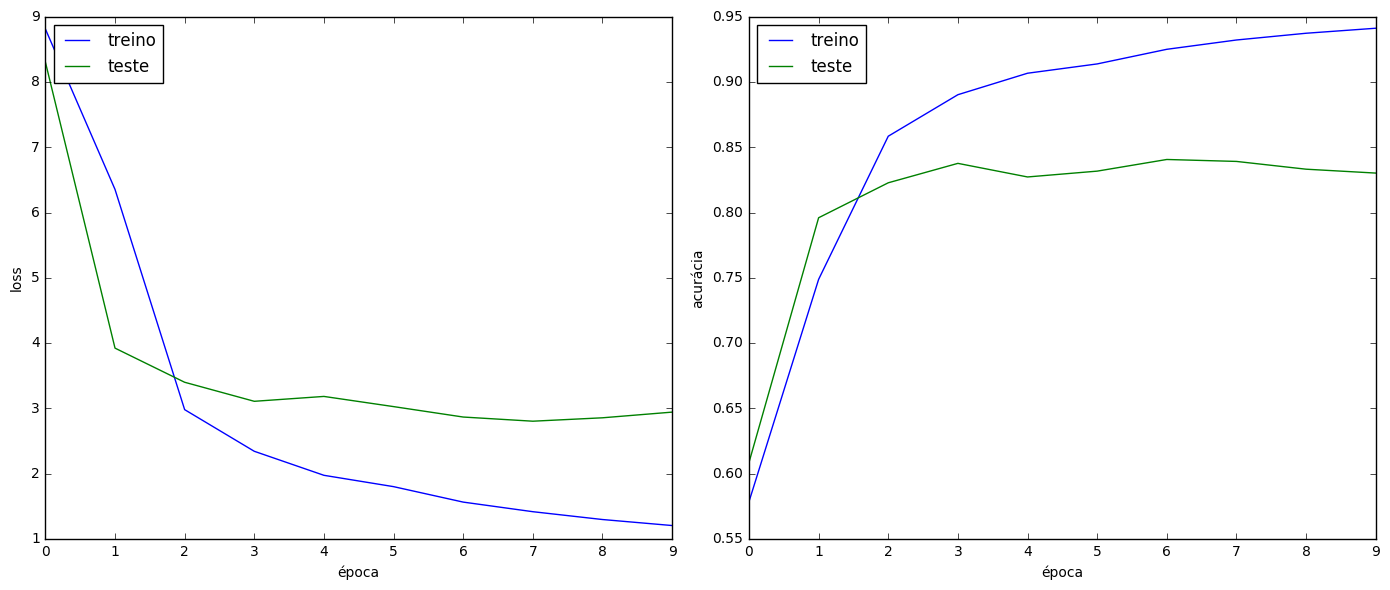

In [4]:
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.05, random_state=42)


history = model.fit(X_train, y_train,
                epochs=10,
                batch_size=512,
                verbose=1,
                validation_data=(X_test,y_test))
plot_history(history)
model.save_weights('SelfAttention.h5')

In [5]:
model.load_weights('SelfAttention.h5')

/Users/lucasosouza/anaconda/envs/udacity/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


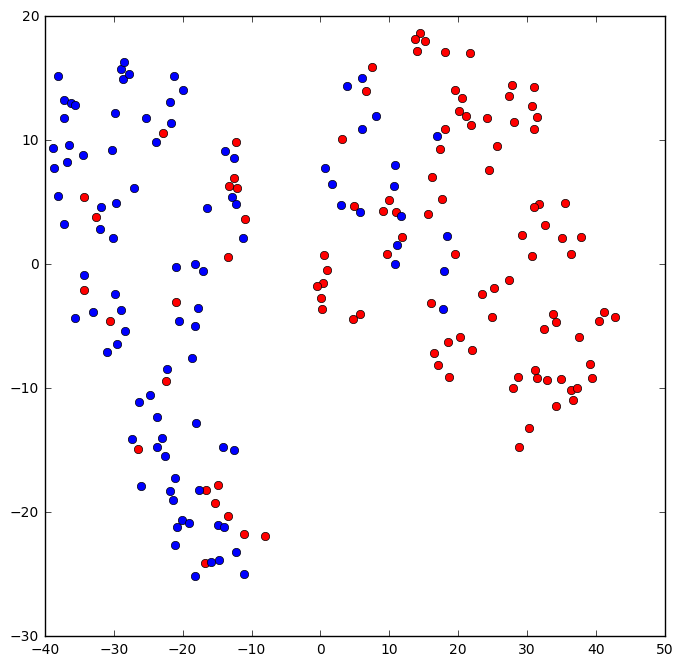

In [11]:
%matplotlib inline

index_word = {v: k for k, v in tokenizer.word_index.items()}
text_file = open("neg.csv", "r",encoding='utf-8')
neg_lines = text_file.readlines()
text_file = open("pos.csv", "r",encoding='utf-8')
pos_lines = text_file.readlines()

texts = neg_lines + pos_lines
texts = tokenizer.texts_to_sequences(texts)


texts2 = []

for t in texts:
    texts2.append('')
    i = 0
    for word in t:
        if i ==0:
            texts2[-1] = texts2[-1] + (index_word.get(word))
            i+=1
        else:
            texts2[-1] = texts2[-1] + ' ' + (index_word.get(word))
            
            
texts_train, texts_test = train_test_split(texts2, test_size=0.05, random_state=42)

pred = visu_model.predict(X_test)

tsne = TSNE(n_components=2, init='pca', random_state=0)
low_dim_embedding = tsne.fit_transform(pred)

def on_move(event):
    visibility_changed = False
    for point, annotation in points_with_annotation:
        should_be_visible = (point.contains(event)[0] == True)

        if should_be_visible != annotation.get_visible():
            visibility_changed = True
            annotation.set_visible(should_be_visible)

    if visibility_changed:        
        plt.draw()

fig = plt.figure(figsize=(8,8))  # in inches
ax = plt.axes()

points_with_annotation = []

for i, label in enumerate(y_test[0:200]):
    x, Y = low_dim_embedding[i, :]
    if label == 1:
        point, = plt.plot(x, Y, 'o', c='blue')
    else:
        point, = plt.plot(x, Y, 'o', c='red')
    
    annotation = ax.annotate(texts_test[i],
        xy=(x, Y), xycoords='data',
        xytext=(x + 1, Y), textcoords='data',
        horizontalalignment="left",
        arrowprops=dict(arrowstyle="simple",
                        connectionstyle="arc3,rad=-0.2"),
        bbox=dict(boxstyle="round", facecolor="w", 
                  edgecolor="0.5", alpha=0.9)
        )

    annotation.set_visible(False)
    points_with_annotation.append([point, annotation])



on_move_id = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.canvas.mpl_connect('draw_event', on_draw)

plt.show()

### Agora vamos visualizar as atenções

In [12]:
%matplotlib inline
index_word = {v: k for k, v in tokenizer.word_index.items()}

def test_lstm_atten(texto):
    #Transforma o texto em sequências
    texto_token = tokenizer.texts_to_sequences([texto])
    t = sequence.pad_sequences(texto_token, maxlen=maxlen)
    
    pred = atten_model.predict(t)
    pred = np.swapaxes(pred,1,2)
    
    tam = len(texto_token[0]) + 5
    
    #recria o texto de entrada com base no vocabulário do tokenizer
    words = []
    for i in reversed(range(maxlen)):
        if index_word.get(t[0][i]):
            words.append(index_word.get(t[0][i]))
        else:
            if i <  (maxlen-tam):
                break
            words.append(' ')
        
    #plota os estados com cada coluna sendo um tempo de recorrência
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(3, 5),dpi=120)
    plt.imshow(np.mean(pred[0,-tam:,:].T, axis=0).reshape(-1,1), cmap='Greys_r')
    plt.yticks(np.arange(tam), reversed(words))
    plt.xticks(np.arange(0))
    plt.show()
    print("Grau de positividade:", model.predict(t)[0,0])

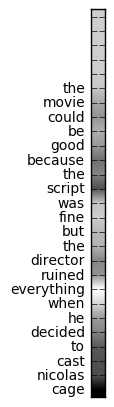

Grau de positividade: 0.007383953


In [13]:
test_lstm_atten('The movie could be good because the script was fine, but the director ruined everything when he decided to cast Nicolas Cage')

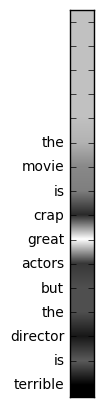

Grau de positividade: 0.034423858


In [14]:
test_lstm_atten('the movie is crap, great actors, but the director is terrible')

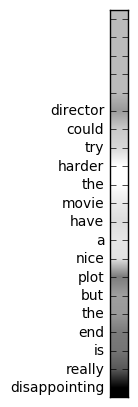

Grau de positividade: 0.006114691


In [15]:
test_lstm_atten('Director could try harder, the movie have a nice plot but the end is really disappointing.')